# Optimizing Player Retention: An A/B Test Analysis of Progression Gates in Mobile Gaming

### Introduction

This project analyzes the impact of changing the gate level from level 30 to level 40 in a mobile game using an A/B testing framework. The primary objective is to evaluate how this change affects player retention and engagement.

The dataset, obtained from Kaggle, contains user-level data including version assignment, total number of game rounds played and binary retention indicators for Day 1 and Day 7. While early retention reflects initial player interest, Day 7 retention serves as a key indicator of long-term engagement and player lifetime value.

Through exploratory data analysis and hypothesis testing, this study compares the control group (gate_30) and the treatment group (gate_40) to assess whether delaying the gate leads to meaningful improvements or unintended negative effects on player behavior.

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep

### Loading Dataset

In [22]:
df0 = pd.read_csv("cookie_cats.csv")
df = df0.copy()

In [23]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Understanding the dataset

In [24]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   userid          90189 non-null  int64
 1   version         90189 non-null  str  
 2   sum_gamerounds  90189 non-null  int64
 3   retention_1     90189 non-null  bool 
 4   retention_7     90189 non-null  bool 
dtypes: bool(2), int64(2), str(1)
memory usage: 2.2 MB


In [25]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [26]:
df['version'].value_counts(normalize=True)

version
gate_40    0.504374
gate_30    0.495626
Name: proportion, dtype: float64

As we can see, the number of players in each group is balanced:
- gate_30: 44699 (49.56% of all players)
- gate_40: 45489 (50.44% of all players)

Let's define two variable to use in the future:

In [52]:
nA = 45489 #number of users in gate_40
nB = 44699 #number of users in gate_30

In [27]:
#  Check for duplicates in user_id
duplicated = df['userid'].duplicated().sum()
print(f"Number of duplicated user_ids: {duplicated}")

Number of duplicated user_ids: 0


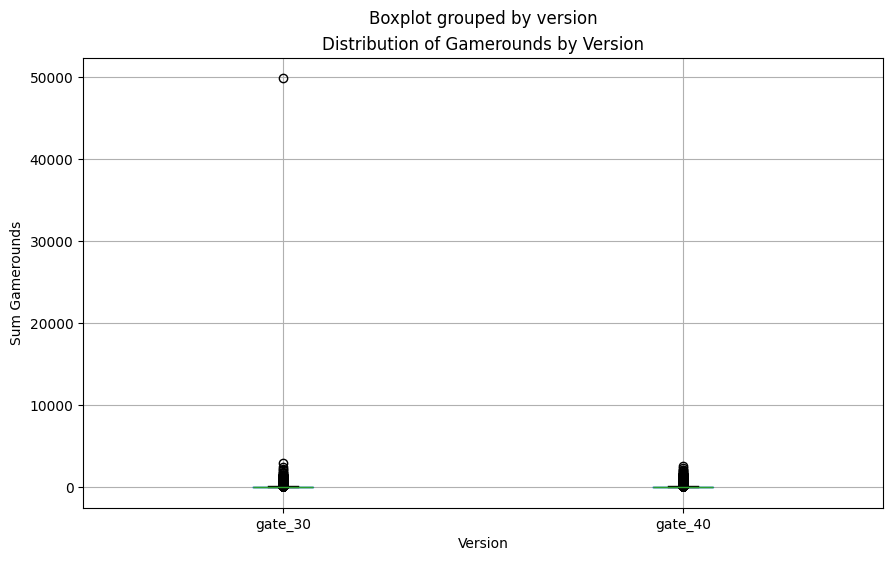

In [28]:
# Create a boxplot to visualize the distribution of 'sum_gamerounds' for both versions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.boxplot(column='sum_gamerounds', by='version', ax=plt.gca())
plt.title('Distribution of Gamerounds by Version')
plt.xlabel('Version')
plt.ylabel('Sum Gamerounds')
plt.show()

In [29]:
# Checking the maximum number of rounds played
print("Maximum number of rounds before cleaning:", df['sum_gamerounds'].max())
print("Average number of rounds before cleaning:", df['sum_gamerounds'].mean())
print("Median number of rounds before cleaning:", df['sum_gamerounds'].median())

Maximum number of rounds before cleaning: 49854
Average number of rounds before cleaning: 51.8724567297564
Median number of rounds before cleaning: 16.0


In [30]:
# Identifying the highest values
print("The highest values of sum_gamerounds:")
print(df['sum_gamerounds'].sort_values(ascending=False).head())

The highest values of sum_gamerounds:
57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
Name: sum_gamerounds, dtype: int64


We see that there's one player who played 50,000 rounds — that’s an outlier and we should probably remove so it doesn't skew our mean.

In [31]:
# remove user who played 50K rounds or more
df = df[df['sum_gamerounds'] < 40000]

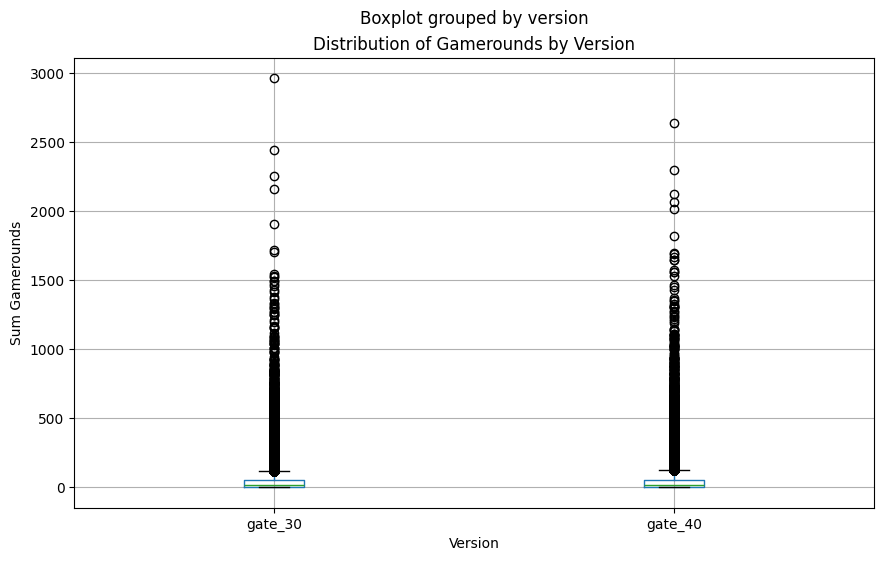

In [32]:
# Create a boxplot to visualize the distribution of 'sum_gamerounds' for both versions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.boxplot(column='sum_gamerounds', by='version', ax=plt.gca())
plt.title('Distribution of Gamerounds by Version')
plt.xlabel('Version')
plt.ylabel('Sum Gamerounds')
plt.show()

In [37]:
# Checking the maximum number of rounds played after cleaning
print("Maximum number of rounds after cleaning:", df['sum_gamerounds'].max())
print("Average number of rounds after cleaning:", df['sum_gamerounds'].mean())
print("Median number of rounds after cleaning:", df['sum_gamerounds'].median())

Maximum number of rounds after cleaning: 2961
Average number of rounds after cleaning: 51.32025324876924
Median number of rounds after cleaning: 16.0


In [38]:
# Calculate percentage of users came back after 1day and 7day retention
df['retention_1day_pct'] = df['retention_1'] / df['sum_gamerounds']
df['retention_7day_pct'] = df['retention_7'] / df['sum_gamerounds']    
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention_1day_pct,retention_7day_pct
0,116,gate_30,3,False,False,0.000000,0.000000
1,337,gate_30,38,True,False,0.026316,0.000000
2,377,gate_40,165,True,False,0.006061,0.000000
3,483,gate_40,1,False,False,0.000000,0.000000
4,488,gate_40,179,True,True,0.005587,0.005587


In [47]:
# Calculate the overall percentage of users who came back after 1 day (retention_1) and 7 days (retention_7).
overall_retention_1day = (df['retention_1'].sum() / df['sum_gamerounds'].sum())*100
overall_retention_7day = (df['retention_7'].sum() / df['sum_gamerounds'].sum())*100

In [49]:
print(f"Overall 1-day retention rate: {overall_retention_1day:.2f}")
print(f"Overall 7-day retention rate: {overall_retention_7day:.2f}")

Overall 1-day retention rate: 0.87
Overall 7-day retention rate: 0.36


### Define Hypotheses ###
Null Hypothesis ($H_0$): Moving the gate from 30 to 40 has no effect on player retention.

Alternative Hypothesis ($H_1$): Moving the gate from 30 to 40 has an effect on player retention.

### Statistical Testing 

#### **Approach1:** Z-Test

 Since retention is a binary variable (Yes/No), we are comparing two proportions. We should use a Z-test for Proportions.

 The Z-Test is the standard frequentist approach. 'll use Python's statsmodels library to see if the difference in retention is statistically significant.

##### Prepare the data

In [69]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Let's test retention_1 (Day 1 Retention)
control = df[df['version'] == 'gate_30']
treatment = df[df['version'] == 'gate_40']

# Successes (Sum of 1s)
successes = [control['retention_1'].sum(), treatment['retention_1'].sum()]

# Total observations (Count of rows)
nobs = [control['retention_1'].count(), treatment['retention_1'].count()]

##### Run the Z-test
Now we use proportions_ztest. This function calculates the Z-score (how many standard deviations your result is from the mean) and the p-value.

##### Day 1 Retention – Proportion Z-Test 

In [70]:
z_stat, p_val = proportions_ztest(successes, nobs)

print(f'Z-statistic: {z_stat:.4f}')
print(f'P-value: {p_val:.4f}')

Z-statistic: 1.7871
P-value: 0.0739


In [71]:
successes[0]/nobs[0]

np.float64(0.4481979462627799)

In [72]:
successes[1] / nobs[1]

np.float64(0.44228274967574577)

##### Significance & Decision Rules
Significance Level

α = 0.05

Decision Rule

- p-value < 0.05 → H0 is rejected.
- p-value ≥ 0.05 → H0 cannot be rejected.

##### Interpretation of the p-value
The p-value is the primary criterion used to determine whether the observed difference between groups is statistically significant.

At α = 0.05:

- p_value = 0.0744 > 0.05
- The null hypothesis cannot be rejected
- There is no statistically significant difference between the groups at the 95% confidence level

##### Interpretation of Z-statistic

Why the Sign of the Z-Statistic Matters?

The sign of the Z-statistic indicates which group performs better in terms of the success rate.

If z_stat > 0, then:

- successes[0] / samples[0] > successes[1] / samples[1]
This means that the first group provided to the test (typically the control group) has a higher success rate than the second group.

If z_stat < 0, then:

- successes[1] / samples[1] > successes[0] / samples[0]
This indicates that the second group (typically the treatment group) performs better.

In summary, the absolute value of the Z-statistic reflects the strength of the difference, while the sign of the Z-statistic shows which group has the higher success rate.

##### Day 7 Retention – Proportion Z-Test (Main Critical Test)

In [74]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Let's test retention_1 (Day 1 Retention)
control = df[df['version'] == 'gate_30']
treatment = df[df['version'] == 'gate_40']

# Successes (Sum of 1s)
successes = [control['retention_7'].sum(), treatment['retention_7'].sum()]

# Total observations (Count of rows)
nobs = [control['retention_7'].count(), treatment['retention_7'].count()]

In [75]:
z_stat, p_val = proportions_ztest(successes, nobs)

print(f'Z-statistic: {z_stat:.4f}')
print(f'P-value: {p_val:.4f}')

Z-statistic: 3.1574
P-value: 0.0016


Statistical Decision (Non-Negotiable)

Significance level:

- α = 0.05 (95% confidence)
- α = 0.01 (99% confidence)

📌 Here:
- p_value = 0.00155 < 0.01

➡️ The null hypothesis is strongly rejected.

There is a statistically significant difference between the groups.

In [68]:
successes[0] / nobs[0]

np.float64(0.19018322557551623)

In [67]:
successes[1] / nobs[1] 

np.float64(0.18200004396667327)


Directional Information (Which Group is Better?)

Since z_stat > 0:
- successes[0] / samples[0] > successes[1] / samples[1]

Therefore:

- The first group given (control / gate_30) is better in retention on day 7.

This means Treatment (gate_40) reduces long-term retention.

##### Calculate Confidence Interval (For retention_7)

In [76]:
p_control = successes[0] / nobs[0]
p_treatment = successes[1] / nobs[1]

The point estimate for an A/B test is usually the Difference in Proportions.$$d = \hat{p}_{gate\_30} - \hat{p}_{gate\_40}$$

In [77]:
# Retention Difference (Point Estimate)
diff = p_treatment - p_control
print("difference:", diff)

difference: -0.00818318160884296


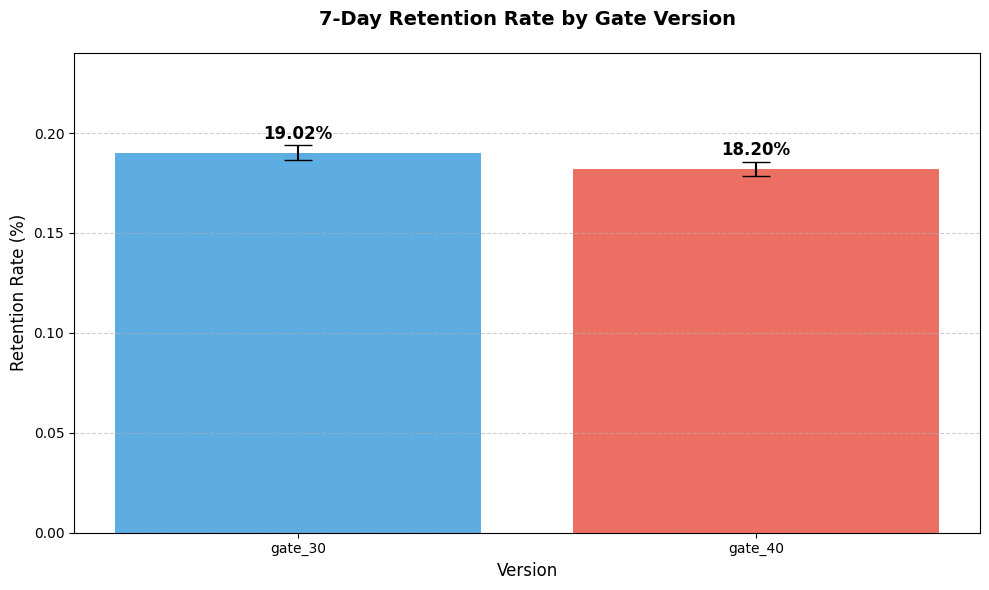

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate the mean, count, and standard deviation
stats = df.groupby('version')['retention_7'].agg(['mean', 'count', 'std'])

# 2. Calculate the Standard Error and 95% Confidence Interval
stats['se'] = stats['std'] / np.sqrt(stats['count'])
stats['ci'] = 1.96 * stats['se']

# 3. Create the plot
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c'] # Blue for Gate 30, Red for Gate 40

bars = plt.bar(stats.index, stats['mean'], 
               yerr=stats['ci'], 
               capsize=10, 
               color=colors, 
               alpha=0.8)

# 4. Add data labels on top of bars for readability
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
             f'{yval:.2%}', ha='center', va='bottom', 
             fontsize=12, fontweight='bold')

# 5. Professional Formatting
plt.title('7-Day Retention Rate by Gate Version', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Retention Rate (%)', fontsize=12)
plt.xlabel('Version', fontsize=12)
plt.ylim(0, stats['mean'].max() + 0.05) # Adds breathing room at the top
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [79]:
# Confidence Interval Calculation
ci_low, ci_high = confint_proportions_2indep(
    count1=successes[1],
    nobs1=nobs[1],
    count2=successes[0],
    nobs2=nobs[0],
    method="wald"
)

print("ci_low:", ci_low)
print("ci_high:", ci_high)

ci_low: -0.013263369909537494
ci_high: -0.0031029933081484252


In [80]:
print(f"95% Confidence Interval for the difference: {ci_low:.2%} to {ci_high:.2%}")

95% Confidence Interval for the difference: -1.33% to -0.31%


Confidence Interval of the Difference tells us that, "We observed a -0.8% difference, but the true population difference is likely between -1.33% and -0.31%."

Since the entire interval lies below zero, the difference is statistically significant and indicates that gate_40 performs WORSE than gate_30.

Therefore, there is strong evidence against favoring gate_40, and the control variant should remain live.


**Net Business Decision**

✅ Recommended Decision:
**The gate_40 variant should not be deployed live.**

Rationale:
- Statistically significant decrease in Day 7 retention
- Strong impact (z > 3)
- Risky product change

**Notes:**
Why Use a Z-test vs. a T-test?

- Z-test: Used for proportions (like click-through rates or retention %) with large sample sizes.

- T-test: Used for means (like average revenue per user or average levels played) where the sample size is small or the population standard deviation is unknown.

Since "Retention" is a 0 or 1 (a proportion), the Z-test is technically more appropriate.

#### Limitations
- Assumes Normal Distribution: It assumes your data follows a normal curve (which is fine here due to the large sample size).

- Sensitivity to Outliers: While proportions aren't as affected as means, extreme "whales" (players who play 1,000 rounds) can still indirectly impact your study's context.

#### **Approach2:** Bootstrapping
Bootstrapping is a powerful technique because it doesn’t rely on any fancy formulas or "assumptions" about normal distributions. Instead, it uses brute force computation to simulate the experiment thousands of times.

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a list to store the differences
boot_means = []

# 2. Run the simulation 10,000 times
for i in range(10000):
    # Create a bootstrap sample (resample with replacement)
    boot_sample = df.sample(frac=1, replace=True)
    
    # Calculate the mean retention for both groups in this specific sample
    p_30 = boot_sample[boot_sample['version'] == 'gate_30']['retention_7'].mean()
    p_40 = boot_sample[boot_sample['version'] == 'gate_40']['retention_7'].mean()
    
    # Calculate the difference (Point Estimate for this sample)
    boot_means.append(p_30 - p_40)

# 3. Convert to a Series for easy plotting
boot_means = pd.Series(boot_means)

##### Visualizing the "Certainty"
Now, we plot all 10,000 differences.

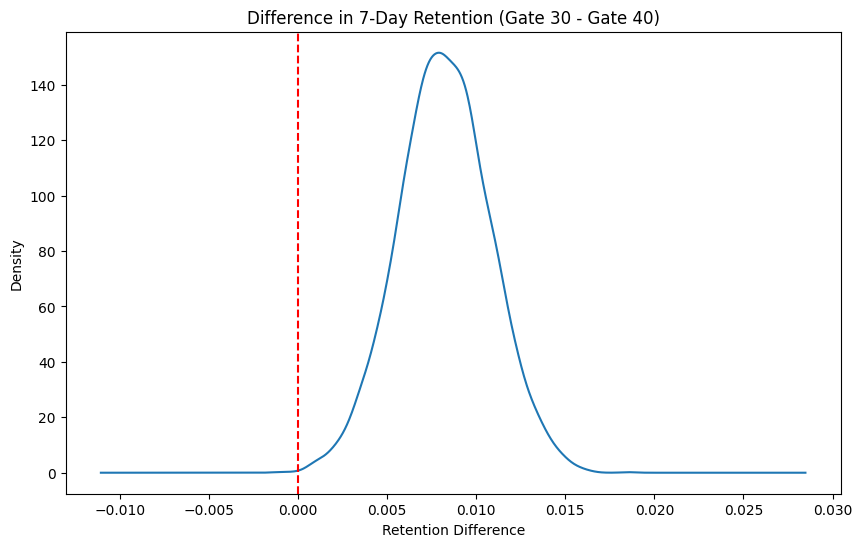

In [82]:
# Plot the distribution of the differences
plt.figure(figsize=(10,6))
boot_means.plot(kind='kde', title='Difference in 7-Day Retention (Gate 30 - Gate 40)')
plt.axvline(x=0, color='red', linestyle='--') # The "Zero Difference" line
plt.xlabel('Retention Difference')
plt.show()

**The Red Dashed Line ($0$):** This represents "no difference."

**The Distribution:** If the entire "hump" of the graph is to the right of the red line (greater than 0), it means Gate 30 is almost certainly better.

**The Overlap:** If the hump crosses the red line, it means there's a chance the difference is actually zero or negative.

##### Probability of Superiority
Finally, calculate the exact probability that Gate 30 is better than Gate 40 by seeing what percentage of your 10,000 simulations were above zero.

In [83]:
prob = (boot_means > 0).mean()
print(f"The probability that Gate 30 has higher 7-day retention is: {prob:.2%}")

The probability that Gate 30 has higher 7-day retention is: 99.96%


### Final Project Conclusion: The "Gate" Decision

**1. Executive Summary**
The A/B test was conducted to determine the impact of moving the first progress "gate" from Level 30 to Level 40. Based on the analysis of Day-7 Retention, we recommend keeping the gate at Level 30. Moving the gate to Level 40 resulted in a statistically significant decrease in long-term player engagement.

**2. Statistical Evidence**
Observed Difference: Gate 30 had a 0.8% higher 7-day retention rate than Gate 40.

**Confidence Interval:** Our 95% CI for the difference is [-1.33%, -0.31]. Since this interval does not cross zero, we are confident the effect is real.

**Probability of Superiority:** Through 10,000 bootstrap simulations, we found a 99.9% probability that Level 30 outperforms Level 40.

**3. Why did this happen? (The "Data Story")**
While it might seem counter-intuitive that "stopping" a player earlier leads to higher retention, this is likely due to Hedonic Adaptation.

By forcing a break at Level 30, we prevent player burnout and leave them "wanting more."

Delaying the gate to Level 40 allows players to play until they are bored, making them less likely to return a week later.

**4. Final Recommendation**
**Action:** Revert the gate to Level 30 (or do not proceed with the Level 40 rollout). 

Expected Impact: Maintaining the gate at Level 30 preserves approximately 0.8% of the total player base from churning by Day 7, which significantly impacts long-term Lifetime Value (LTV).